**摇臂实验**
    @author: piperliu
    @github: [PiperLiu/Reinforcement-Learning-practice-zh](https://github.com/PiperLiu/Reinforcement-Learning-practice-zh)
    @csdn: [piperliu@qq.com的博客](https://blog.csdn.net/weixin_42815609)

founded in 2019-12-10

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### 产生摇臂

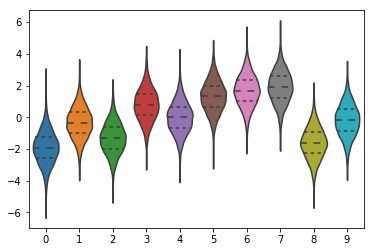

In [2]:
# 10个摇臂的编号，从0开始
K = np.array(range(10))
# 摇臂的奖赏：sigma为1的正态分布，mu不同，下面是生成mu的
R_mu = np.array([np.random.uniform(-2,2) for i in range(10)])
def K_Reward(R_mu_):
    return np.random.normal(loc=R_mu_, scale=1.0)

# 产生5000个样本，查看摇臂图像
demoData = np.array([
    [K_Reward(R_mu[i]) for i in range(R_mu.shape[0])]
    for j in range(5000)])
sns.violinplot(data=demoData, inner="quartile")
del demoData

### epsilon-贪心算法

使用增量式计算的样本均值作为指标，公式为，对于每一个动作，有：

$$Q_n = \frac{R_1+R_2+...+R_{n-1}}{n-1}$$

程序实现时，使用上述方法计算该指标，$R_{n}$表示这一动作第n次执行时获得的收益。每个动作执行的次数记录在字典count中，实际上较为浪费空间，可以简化为：

$$Q_{n+1} = Q_n + \frac{1}{n} \left[ R_n - Q_n \right]$$

推导较为简单，略。

In [3]:
def greed_epsilon(R_mu, t, epsilon):
    # 输入摇臂分布、测试次数、epsilon
    reward = 0
    array = []
    # 每个摇臂的摇到的次数、价值
    count = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))
    Q = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))
    
    for i in range(t):
        if np.random.uniform(0, 1) < epsilon:
            k = np.random.randint(0, R_mu.shape[0])
        else:
            k = max(Q, key=Q.get)
        
        reward_current = K_Reward(R_mu_=R_mu[k])
        reward += reward_current
        Q[k] = (Q[k] * count[k] + reward_current) / (count[k] + 1)
        count[k] = count[k] + 1
        array.append(reward / (i + 1))
    
    return array

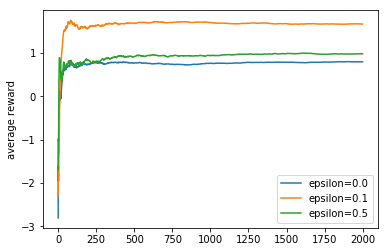

In [4]:
# excute and plot
t = 2000
T = np.arange(t)
demo_0dot0 = greed_epsilon(R_mu, t, epsilon=0.0)
demo_0dot1 = greed_epsilon(R_mu, t, epsilon=0.1)
demo_0dot5 = greed_epsilon(R_mu, t, epsilon=0.5)

plt.plot(T, demo_0dot0)
plt.plot(T, demo_0dot1)
plt.plot(T, demo_0dot5)
plt.legend(("epsilon=0.0", "epsilon=0.1", "epsilon=0.5"))
plt.ylabel("average reward")
plt.show()

如上图，可以注意到，在迭代次数500后，epsilon=0.1的贪心算法效果几乎总比其他两个好。
原因可能有：
- 比0.0好是因为0.1不陷入局部最优解，总有跳出去“探索exploration”的可能；
- 比0.5好是因为0.1能有效利用现有信息，选择较好的摇臂。

在信息完全的情况下，我们知道，2000步中每次都应该选择R_mu值最高的摇臂，这样在大样本情况下平均收益才是最高的。**如果算法足够聪明的话，它应该在多次迭代后能判断出谁是最优动作，并且总是做出最优动作。**下面测试最优动作。

In [5]:
def greed_epsilon_return_action(R_mu, t, epsilon):
    # 输入摇臂分布、测试次数、epsilon
    reward = 0
    array = []
    
    optimal_actions = [0]
    # 找到最优动作
    optimalAction = np.argmax(R_mu)
    
    # 每个摇臂的摇到的次数、价值
    count = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))
    Q = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))

    for i in range(t):
        if np.random.uniform(0, 1) < epsilon:
            k = np.random.randint(0, R_mu.shape[0])
        else:
            k = max(Q, key=Q.get)
        
        reward_current = K_Reward(R_mu_=R_mu[k])
        reward += reward_current
        Q[k] = (Q[k] * count[k] + reward_current) / (count[k] + 1)
        count[k] = count[k] + 1
        array.append(reward / (i + 1))
        
        if k == optimalAction:
            optimal_actions.append((optimal_actions[-1] * i + 1) / (i + 1))
        else:
            optimal_actions.append(optimal_actions[-1] * i / (i + 1))
    
    optimal_actions.pop(-1)
    
    return (array, optimal_actions)

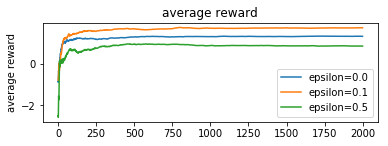

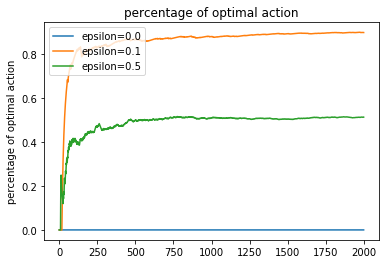

In [6]:
# excute and plot
t = 2000
T = np.arange(t)
demo_0dot0 = greed_epsilon_return_action(R_mu, t, epsilon=0.0)
demo_0dot1 = greed_epsilon_return_action(R_mu, t, epsilon=0.1)
demo_0dot5 = greed_epsilon_return_action(R_mu, t, epsilon=0.5)

fig = plt.figure()
fig.add_subplot(211)
plt.title("average reward")
plt.plot(T, demo_0dot0[0])
plt.plot(T, demo_0dot1[0])
plt.plot(T, demo_0dot5[0])
plt.legend(("epsilon=0.0", "epsilon=0.1", "epsilon=0.5"))
plt.ylabel("average reward")
plt.show()
fig.add_subplot(212)
plt.title("percentage of optimal action")
plt.plot(T, demo_0dot0[1])
plt.plot(T, demo_0dot1[1])
plt.plot(T, demo_0dot5[1])
plt.legend(("epsilon=0.0", "epsilon=0.1", "epsilon=0.5"))
plt.ylabel("percentage of optimal action")
plt.show()

如上图，应该注意：
- 这里的贪心算法并不会把所有摇臂都遍历一遍；
- 因此epsilon=0.0的情况要么最优（k=optimal摇臂，并且一开始为正值），要么很差（陷入局部最优）。

### 非平稳问题

$$Q_{n+1} = Q_n + \frac{1}{n} \left[ R_n - Q_n \right]$$

观察上式，可以看出，权重$\frac{1}{n}$在逐渐减小。对于一个平稳序列而言，这是必要的，因为$\frac{1}{n}$满足下列条件：

$$\sum^{\infty}_{n=1} \alpha_n (a) = \infty \text{ and } \sum^{\infty}_{n=1} \alpha^2_n (a) < \infty$$

即，有足够大的步长能克服任何初始条件及随机波动，并且最终步长能变小，保证收敛。

**但是，非平稳序列不适合上述规律。**因此提出固定步长的更新规则：

$$Q_{n+1} = Q_{n} + \alpha \left[ R_n - Q_n \right]$$

其中，步长$\alpha \in (0,1]$是一个常数，上式可以推导为“指数近因加权平均”的形式：

$$Q_{n+1} = (1-\alpha )^n Q_1 + \sum^n_{i=1} \alpha (1-\alpha )^{n-i} R_i$$

可见，越是新的收益，其对评价指标影响就越大。

尽管强化学习应用在平稳序列的场景中较多，业界还是倾向于使用固定步长而非$\frac{1}{n}$。

### 乐观初始值

上例中，每台摇臂的初始值都设为$Q_1 (a) = 0$。如果将每台摇臂的初始值都设为$Q_1 (a) = 5$，则贪心算法会去尝试每台摇臂。原因：每台摇臂的一次奖励一般不会达到5之高。因此，在开始时，测试任意一台摇臂，机器都会感到“失望”，转向下一个没用过的摇臂。

如此，鼓励了机器对每台摇臂进行测试，这种鼓励试探的技术叫作“乐观初始值”。

下面是代码测试：
- 以最优动作占比为评价指标；
- 采用恒定步长参数；
- epsilon=0.1 & 不使用乐观初始值作对比。

In [16]:
def greed_epsilon_encourage_exploration(R_mu, t, epsilon, q):
    
    reward = 0
    array = []
    
    optimal_actions = [0]
    # 找到最优动作
    optimalAction = np.argmax(R_mu)
    
    # 每个摇臂的摇到的次数、价值
    count = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))
    Q = dict(zip(list(range(R_mu.shape[0])), [q] * R_mu.shape[0]))

    for i in range(t):
        if np.random.uniform(0, 1) < epsilon:
            k = np.random.randint(0, R_mu.shape[0])
        else:
            k = max(Q, key=Q.get)
        
        reward_current = K_Reward(R_mu_=R_mu[k])
        Q[k] = Q[k] + 0.1 * (reward_current - Q[k])
        
        reward += reward_current
        array.append(reward / (i + 1))
        
        if k == optimalAction:
            optimal_actions.append((optimal_actions[-1] * i + 1) / (i + 1))
        else:
            optimal_actions.append(optimal_actions[-1] * i / (i + 1))
    
    optimal_actions.pop(-1)
    
    return (array, optimal_actions)

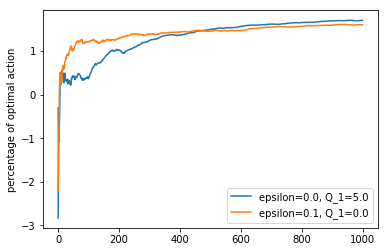

In [17]:
# excute and plot
t = 1000
T = np.arange(t)
demo_0dot0 = greed_epsilon_encourage_exploration(R_mu, t, epsilon=0.0, q=5)
demo_0dot1 = greed_epsilon_encourage_exploration(R_mu, t, epsilon=0.1, q=0)

plt.plot(T, demo_0dot0[0])
plt.plot(T, demo_0dot1[0])
plt.legend(("epsilon=0.0, Q_1=5.0", "epsilon=0.1, Q_1=0.0"))
plt.ylabel("percentage of optimal action")
plt.show()

### 修正步长

如果采样不平均，可以用修正步长：

$$\beta_n = \frac{\alpha}{\overline{o}_n}$$

其中，$\overline{o}_n = \overline{o}_{n-1} + \alpha (1 - \overline{o}_{n-1})$，并且$\overline{o}_{0} = 0$。此时，可证$Q_n$是对初始值无偏的指数近因加权平均。

### 基于置信度上界的动作选择（UCB）

基于置信度上界（upper confidence bound, UCB）的动作思想是，基于潜力选择动作。如果一个动作被做过的次数较少，则认为其潜力较大，公式：

$$A_t = \mathop{\arg \max}_{a} \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t (a)}} \right]$$

其中，c是大于0的数，决定置信水平。$N_t(a)$是t时刻前动作a被选择的次数。如果$N_t(a)=0$，则a就被认为是满足最大化条件的动作。可以看出，有关系：

$$t = \sum_a N_t (a)$$

下面是代码测试，评价指标为平均收益，对照组为：
- 参数不同的c；
- epsilon-贪心算法。

In [9]:
def greed_epsilon(R_mu, t, epsilon):
    # 输入摇臂分布、测试次数、epsilon
    reward = 0
    array = []
    # 每个摇臂的摇到的次数、价值
    count = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))
    Q = dict(zip(list(range(R_mu.shape[0])), [0] * R_mu.shape[0]))
    
    for i in range(t):
        if np.random.uniform(0, 1) < epsilon:
            k = np.random.randint(0, R_mu.shape[0])
        else:
            k = max(Q, key=Q.get)
        
        reward_current = K_Reward(R_mu_=R_mu[k])
        reward += reward_current
        Q[k] = (Q[k] * count[k] + reward_current) / (count[k] + 1)
        count[k] = count[k] + 1
        array.append(reward / (i + 1))
    
    return array

def ucb_c(R_mu, t, c):
    reward = 0
    array = []
    N_list = list(range(R_mu.shape[0]))
    Q_list = list(range(R_mu.shape[0]))
    
    for i in range(t):
        
        try:
            Action = N_list.index(0)
        except ValueError:
            t = sum(N_list)
            polynomial = [Q_list[a] + c * (np.log(t) / N_list[a]) ** 0.5
                             for a in range(R_mu.shape[0])]
            Action = np.argmax(polynomial)
        
        reward_current = K_Reward(R_mu_=R_mu[Action])
        reward += reward_current
        Q_list[Action] = (Q_list[Action] * N_list[Action] + reward_current) / (N_list[Action] + 1)
        N_list[Action] = N_list[Action] + 1
        array.append(reward / (i + 1))
    
    return array

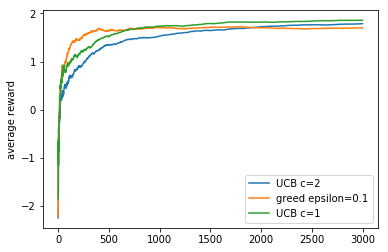

In [10]:
# excute and plot
t = 3000
T = np.arange(t)
demo_ucb_2 = ucb_c(R_mu, t, c=2)
demo_0dot1 = greed_epsilon(R_mu, t, epsilon=0.1)
demo_ucb_1 = ucb_c(R_mu, t, c=1)

plt.plot(T, demo_ucb_2)
plt.plot(T, demo_0dot1)
plt.plot(T, demo_ucb_1)
plt.legend(("UCB c=2", "greed epsilon=0.1", "UCB c=1"))
plt.ylabel("average reward")
plt.show()

如上，与书上不同，ucb确实有优势，但是优势体现在2000次（甚至更多）迭代后，greed平稳，而ucb的指标仍处于上升趋势。

### 梯度赌博机算法



#### soft分布于偏好函数$H_t(a)$的更新

偏好函数本身的值并不重要，重要的是一个动作相比于另一个动作的偏好，因此，选择动作的概率分布使用softmax分布：

$$Pr_{A_t = a} = \frac{e^{H_t(a)}}{\sum_{b=1}^{k} e^{H_t(b)}} = \pi_t(a)$$

$\pi_t(a)$表示动作a在t时刻被选择的概率，所有偏好函数的初始值都相同（可为0）。

**可以证明，在两种动作的情况下，softmax分布与通常在统计学和人工神经网络中使用的logistic或sigmoid函数给出的结果相同。** 这里我未证明。

则，偏好函数更新遵守如下规则：

|$H_{t+1}(A_t) = H_t(A_t) + \alpha (R_t - \overline{R_t})(1-\pi_t(A_t))$|对于被选择的动作$A_t$| (1) |
|---|---|---|
|$H_{t+1}(a) = H_t(a) - \alpha (R_t - \overline(R_t) \pi_t(a))$|对于所有$a \not= A_t$| (2) |

其中，a是一个大于0的数，表示步长。$\overline{R_t}$是时刻t内所有收益的平均值，称为基准项。

**个人思考：为什么更新偏好函数时要考虑概率呢？** 答：对于(1)式，若本身概率较大，则$H_{t+1}$不会加太多，若本身概率$\pi_t=1$，则$H_{t+1}$不用更新。

上述思考有一定道理，但是这个更新公式的合理性可以在数学上证明。具体请参考我的CSDN博文：[【证明分析】梯度赌博机算法中，偏好函数更新：梯度上升公式是精确梯度上升的随机近似：https://blog.csdn.net/weixin_42815609/article/details/103532804](https://blog.csdn.net/weixin_42815609/article/details/103532804)或参考本仓库中的[markdown文件](../mathematics/梯度赌博机算法中，偏好函数更新：梯度上升公式是精确梯度上升的随机近似的证明.md)。

#### 代码测试

首先，修改一下K摇臂的奖励：均值从0改为+4。

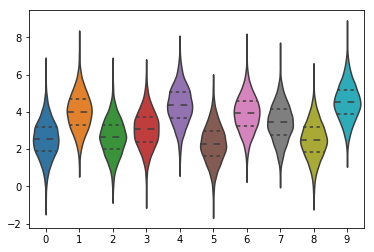

In [11]:
# 摇臂的奖赏：sigma为1的正态分布，mu不同，下面是生成mu的
R_mu_grad = np.array([np.random.uniform(2,6) for i in range(10)])
def K_Reward(R_mu_):
    return np.random.normal(loc=R_mu_, scale=1.0)

# 产生5000个样本，查看摇臂图像
demoData = np.array([
    [K_Reward(R_mu_grad[i]) for i in range(R_mu_grad.shape[0])]
    for j in range(5000)])
sns.violinplot(data=demoData, inner="quartile")
del demoData

测试四种情况：
- 含基准项$\overline(R_t)$，$\alpha=0.1$；
- 含基准项$\overline(R_t)$，$\alpha=0.4$；
- 不含基准项，$\overline(R_t)=0$，$\alpha=0.1$；
- 不含基准项，$\overline(R_t)=0$，$\alpha=0.4$。

首先，为了应用概率选择公式$Pr_{A_t = a} = \frac{e^{H_t(a)}}{\sum_{b=1}^{k} e^{H_t(b)}} = \pi_t(a)$，实现轮盘赌算法。

In [12]:
def RouletteWheelSelection(P):
    # @para: P为一维向量，元素依次为概率
    # @return: 返回选择了第selection个
    
    length = len(P)
    Probability = .0
    
    dart = np.random.uniform(0, 1)
    selection = 0
    
    for selection in range(length):
        Probability = Probability + P[selection]
        if Probability > dart:
            break
    
    return selection

然后，实现梯度赌博机算法。

In [13]:
def grad_alpha(R_mu, t, alpha, reward_base_exist=True):
    reward = 0
    reward_base = 0
    array = []
    
    # 找到最优动作
    optimalAction = np.argmax(R_mu)
    optimal_actions = [0]
    
    Hobby = [0] * R_mu.shape[0]
    Pr = [0] * R_mu.shape[0]
    
    
    for i in range(t):

        # 更新动作概率
        Pr_denominator = sum([np.exp(Hobby[x]) for x in range(len(Hobby))])
        Pr = [(np.exp(Hobby[x]) / Pr_denominator) for x in range(len(Hobby))]
        
        # 选择动作
        Action = RouletteWheelSelection(Pr)
        
        # 计算收益        
        reward_current = K_Reward(R_mu_=R_mu[Action])
        if reward_base_exist==True:
            reward_base = (reward_base * i + reward_current) / (i + 1)
        reward += reward_current
        array.append(reward / (i + 1))
        
        # 更新偏好函数
        for x in range(len(Hobby)):
            Hobby[x] = Hobby[x] - alpha * (reward_current - reward_base) * Pr[x]
        Hobby[Action] = Hobby[Action] + alpha * (reward_current - reward_base) * (1 - Pr[Action])

        # 计算最优动作出现概率
        if Action == optimalAction:
            optimal_actions.append((optimal_actions[-1] * i + 1) / (i + 1))
        else:
            optimal_actions.append(optimal_actions[-1] * i / (i + 1))
        
    optimal_actions.pop(-1)
            
    return (array, optimal_actions)

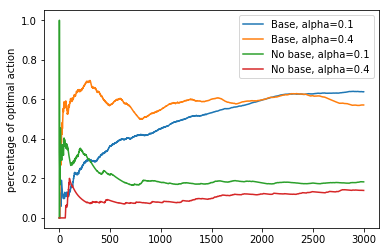

In [14]:
# excute and plot
t = 3000
T = np.arange(t)
demo_R01 = grad_alpha(R_mu_grad, t, 0.1)
demo_R04 = grad_alpha(R_mu_grad, t, 0.4)
demo_N01 = grad_alpha(R_mu_grad, t, 0.1, False)
demo_N04 = grad_alpha(R_mu_grad, t, 0.4, False)

plt.plot(T, demo_R01[1])
plt.plot(T, demo_R04[1])
plt.plot(T, demo_N01[1])
plt.plot(T, demo_N04[1])
plt.legend(("Base, alpha=0.1", "Base, alpha=0.4", "No base, alpha=0.1", "No base, alpha=0.4"))
plt.ylabel("percentage of optimal action")
plt.show()

如上图，有基准项的效果总比无基准项的好。

### 关联搜索（上下文相关的赌博机）

如果允许动作可以影响下一时刻的情景和收益，那么这就是完整的强化学习问题。

### 小结

多种算法对比一下。

对于每种算法，对于每个参数，走3000步，走30次，取平均值。

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


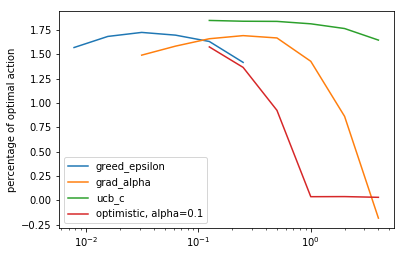

In [35]:
T_greed = [2 ** (x - 7) for x in range(6)]
T_grad = [2 ** (x - 5) for x in range(8)]
T_ucb = [2 ** (x - 3) for x in range(6)]
T_optimistic = [2 ** (x - 3) for x in range(6)]

reward_greed = [0] * 6
reward_grad = [0] * 8
reward_ucb = [0] * 6
reward_optimistic = [0] * 6

for i in range(30):
    t = 3000
    for j in range(6):
        para = T_greed[j]
        temp = greed_epsilon(R_mu, t, epsilon=para)
        reward_greed[j] = ((reward_greed[j] * i) + temp[-1]) / (i + 1)
    for j in range(8):
        para = T_grad[j]
        temp = grad_alpha(R_mu, t, alpha=para)
        temp = temp[0]
        reward_grad[j] = ((reward_grad[j] * i) + temp[-1]) / (i + 1)
    for j in range(6):
        para = T_ucb[j]
        temp = ucb_c(R_mu, t, c=para)
        reward_ucb[j] = ((reward_ucb[j] * i) + temp[-1]) / (i + 1)
    for j in range(6):
        para = T_optimistic[j]
        temp = greed_epsilon_encourage_exploration(R_mu, t, epsilon=para, q=5)
        temp = temp[0]
        reward_optimistic[j] = ((reward_optimistic[j] * i) + temp[-1]) / (i + 1)

plt.xscale('log')
plt.plot(T_greed, reward_greed)
plt.plot(T_grad, reward_grad)
plt.plot(T_ucb, reward_ucb)
plt.plot(T_optimistic, reward_optimistic)
plt.legend(("greed_epsilon", "grad_alpha", "ucb_c", "optimistic, alpha=0.1"))
plt.ylabel("percentage of optimal action")
plt.show()

果真如书上所说：这个问题中，ucb效果最好。但是书上同时指出，梯度算法比贪婪更有效。书上的图片见[这篇文章](https://mp.weixin.qq.com/s/ghPSKJ9T4-ayz7H0BCQTWA)的末尾。

值得注意的是，[这篇文章](https://mp.weixin.qq.com/s/ghPSKJ9T4-ayz7H0BCQTWA)的复现代码不如我写的代码普适性强。

本章结。收获不小。
2019-12-14 01:07:57